In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
from PIL import Image, ImageOps

In [2]:
run_metrics_df = pd.read_csv('../data/processed/run_plays_12-22_about2yards.csv')

In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Down Sample

In [9]:
# Clean data
def clean_data(metrics_df):
    metrics_df['event'].replace('assist', 'tackle', inplace=True)
    metrics_df.drop(metrics_df[metrics_df['event'] == 'forcedFumble'].index, inplace=True)
    
    metrics_df['tackler_time_to_contact'].replace([np.inf, -np.inf], 1000, inplace=True)
    metrics_df['ball_carrier_time_to_contact'].replace([np.inf, -np.inf], 1000, inplace=True)
    metrics_df['diff_time_to_contact'].replace([np.inf, -np.inf], 1000, inplace=True)
    
    # must be within field of play, and less than 5 seconds from contact point at current speed
    metrics_df['make_contact'] = ((metrics_df['x_contact'] < 110) & 
                                  (metrics_df['x_contact'] > 0) &
                                  (abs(metrics_df['diff_time_to_contact']) < 5)
                                 )
    
    metrics_df['in_field'] = ((metrics_df['x_contact'] < 110) & 
                          (metrics_df['x_contact'] > 0) &
                          (metrics_df['y_contact'] < 53.3) & 
                          (metrics_df['y_contact'] > 0)
                         )
    # reduce data to only contact in field of play
    metrics_df_in_field = metrics_df[metrics_df['in_field'] & (metrics_df['behind_player'] == False)]
    return metrics_df_in_field

In [15]:
def plotting_changes(metrics_df):
    metrics_df['momentum_x_abs'] = abs(metrics_df['momentum_x'])
    metrics_df['momentum_x_abs_ball_carrier'] = abs(metrics_df['momentum_x_ball_carrier'])
    metrics_df['contact_angle_momentum_abs'] = abs(metrics_df['contact_angle_momentum'])
    metrics_df['Outcome'] = metrics_df['event'].apply(lambda x: 'Tackle' if x == 'tackle' else 'Missed Tackle')
    metrics_df['Defender Momentum'] = metrics_df['momentum']
    metrics_df['Ball Carrier Momentum'] = metrics_df['momentum_ball_carrier']
    metrics_df['Defender Endzone Momentum (abs)'] = metrics_df['momentum_x_abs']
    metrics_df['Ball Carrier Endzone Momentum (abs)'] = metrics_df['momentum_x_abs_ball_carrier']
    metrics_df['Defender Sideline Momentum'] = metrics_df['momentum_y']
    metrics_df['Ball Carrier Sideline Momentum'] = metrics_df['momentum_y_ball_carrier']
    metrics_df['Defender Sideline Momentum (abs)'] = metrics_df['momentum_y_abs']
    metrics_df['Ball Carrier Sideline Momentum (abs)'] = metrics_df['momentum_y_abs_ball_carrier']
    metrics_df['Defender Perpendicular Momentum'] = metrics_df['contact_angle_momentum_y']
    metrics_df['Defender Perpendicular Momentum (abs)'] = metrics_df['contact_angle_momentum_y_abs']
    metrics_df['Defender Parallel Momentum (abs)'] = metrics_df['contact_angle_momentum_abs']
    return metrics_df

In [10]:
run_metrics_df = clean_data(run_metrics_df)

In [11]:
sampled_df = run_metrics_df.groupby('event').apply(lambda x: x.sample(n=629, random_state=42))
sampled_df = sampled_df[sampled_df['event'] != 'None']

In [12]:
sampled_df_2 = run_metrics_df.groupby('event').apply(lambda x: x.sample(n=629))
sampled_df_2 = sampled_df_2[sampled_df_2['event'] != 'None']

In [13]:
sampled_df['momentum_x_abs'] = abs(sampled_df['momentum_x'])
sampled_df['momentum_x_abs_ball_carrier'] = abs(sampled_df['momentum_x_ball_carrier'])
sampled_df['contact_angle_momentum_abs'] = abs(sampled_df['contact_angle_momentum'])

In [16]:
sampled_df = plotting_changes(sampled_df)

# Linear Regression

In [17]:
import statsmodels.api as sm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [18]:
data_cols_1 = ['s', 'a', 'x', 'y', 'in_phase',
               's_ball_carrier', 'a_ball_carrier',
               'x_ball_carrier', 'y_ball_carrier',
               'in_phase_ball_carrier']
data_cols_2 = ['contact_angle_momentum',
               'contact_angle_momentum_y_abs']
data_cols_3 = ['momentum', 'momentum_x', 'momentum_y_abs',
               'momentum_ball_carrier', 'momentum_x_ball_carrier',
               'momentum_y_abs_ball_carrier']
# separate models - raw, plane of field, plane of ball carrier
    # model selection criteria (BIC, AIC) may or may not be valid for case control data???

In [19]:
sampled_df['target'] = sampled_df['event'].apply(lambda x: 1 if x == 'tackle' else 0)

No standardization performed, not 100% sure if this is right

### Plane of Field Momentum

In [20]:
model_field = sm.Logit(sampled_df['target'], sampled_df[data_cols_1 + data_cols_3])
result_field = model_field.fit()
result_field.summary()
# p|z| probability of observing data if there was no effect

Optimization terminated successfully.
         Current function value: 0.609470
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                 1258
Model:                          Logit   Df Residuals:                     1242
Method:                           MLE   Df Model:                           15
Date:                Tue, 02 Jan 2024   Pseudo R-squ.:                  0.1207
Time:                        22:01:16   Log-Likelihood:                -766.71
converged:                       True   LL-Null:                       -871.98
Covariance Type:            nonrobust   LLR p-value:                 1.527e-36
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
s                               0.2354      0.102      2.302      0.021       0.035       0.436
a                              -0.1277      0.046     -2.776      0.006      -0.218      -0.038
x                               0.5957      0.131      4.563      0.000       0.340       0.852
y                               0.0248      0.048      0.511      0.609      -0.070       0.120
in_phase                        0.5054      0.169      2.988      0.003       0.174       0.837
s_ball_carrier                 -0.2961      0.176     -1.685      0.092      -0.641       0.048
a_ball_carrier                 -0.0978      0.046     -2.107      0.035      -0.189      -0.007
x_ball_carrier                 -0.5876      0.131     -4.495      0.000      -0.844      -0.331
y_ball_carrier                 -0.0050      0.048     -0.105      0.917      -0.099       0.089
in_phase_ball_carrier           1.2058      0.290      4.155      0.000       0.637       1.775
momentum                       -0.0017      0.001     -3.192      0.001      -0.003      -0.001
momentum_x                      0.0011      0.000      4.706      0.000       0.001       0.002
momentum_y_abs                  0.0005      0.000      1.719      0.086   -7.57e-05       0.001
momentum_ball_carrier          -0.0018      0.001     -1.837      0.066      -0.004       0.000
momentum_x_ball_carrier         0.0016      0.001      3.227      0.001       0.001       0.003
momentum_y_abs_ball_carrier     0.0011      0.000      2.584      0.010       0.000       0.002
===============================================================================================
"""

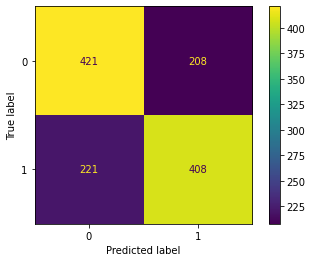

In [21]:
sampled_df['pred_field'] = result_field.predict(sampled_df[data_cols_1 + data_cols_3])
prediction_field = np.round(sampled_df['pred_field'])
cm_field = confusion_matrix(sampled_df['target'], prediction_field)
disp_field = ConfusionMatrixDisplay(confusion_matrix=cm_field)
disp_field.plot()
plt.show()

In [22]:
print(classification_report(sampled_df['target'],  prediction_field))

              precision    recall  f1-score   support

           0       0.66      0.67      0.66       629
           1       0.66      0.65      0.66       629

    accuracy                           0.66      1258
   macro avg       0.66      0.66      0.66      1258
weighted avg       0.66      0.66      0.66      1258



### Both Planes of Momentum

In [23]:
model_both = sm.Logit(sampled_df['target'], sampled_df[data_cols_1 + data_cols_3 + data_cols_2])
result_both = model_both.fit()
result_both.summary()

Optimization terminated successfully.
         Current function value: 0.606823
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                 1258
Model:                          Logit   Df Residuals:                     1240
Method:                           MLE   Df Model:                           17
Date:                Tue, 02 Jan 2024   Pseudo R-squ.:                  0.1245
Time:                        22:01:17   Log-Likelihood:                -763.38
converged:                       True   LL-Null:                       -871.98
Covariance Type:            nonrobust   LLR p-value:                 9.762e-37
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
s                                0.2200      0.103      2.137      0.033       0.018       0.422
a                               -0.1273      0.047     -2.708      0.007      -0.219      -0.035
x                                0.5478      0.137      4.011      0.000       0.280       0.815
y                                0.0237      0.049      0.488      0.626      -0.072       0.119
in_phase                         0.5412      0.171      3.161      0.002       0.206       0.877
s_ball_carrier                  -0.2907      0.177     -1.645      0.100      -0.637       0.056
a_ball_carrier                  -0.1010      0.047     -2.161      0.031      -0.193      -0.009
x_ball_carrier                  -0.5398      0.137     -3.947      0.000      -0.808      -0.272
y_ball_carrier                  -0.0045      0.048     -0.092      0.927      -0.099       0.090
in_phase_ball_carrier            1.2093      0.292      4.135      0.000       0.636       1.782
momentum                        -0.0008      0.001     -1.285      0.199      -0.002       0.000
momentum_x                       0.0011      0.000      3.292      0.001       0.000       0.002
momentum_y_abs                   0.0007      0.000      2.203      0.028    7.98e-05       0.001
momentum_ball_carrier           -0.0020      0.001     -1.961      0.050      -0.004    -1.1e-06
momentum_x_ball_carrier          0.0018      0.001      3.299      0.001       0.001       0.003
momentum_y_abs_ball_carrier      0.0012      0.000      2.718      0.007       0.000       0.002
contact_angle_momentum          -0.0004      0.000     -1.502      0.133      -0.001       0.000
contact_angle_momentum_y_abs    -0.0010      0.000     -2.462      0.014      -0.002      -0.000
================================================================================================
"""

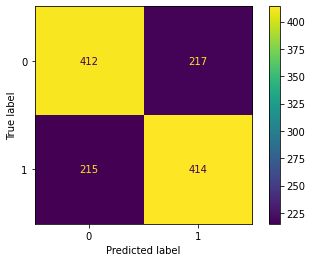

In [24]:
sampled_df['pred_both'] = result_both.predict(sampled_df[data_cols_1 + data_cols_3 + data_cols_2])
prediction_both = np.round(sampled_df['pred_both'])
cm_both = confusion_matrix(sampled_df['target'], prediction_both)
disp_both = ConfusionMatrixDisplay(confusion_matrix=cm_both)
disp_both.plot()
plt.show()

In [25]:
print(classification_report(sampled_df['target'],  prediction_both))

              precision    recall  f1-score   support

           0       0.66      0.66      0.66       629
           1       0.66      0.66      0.66       629

    accuracy                           0.66      1258
   macro avg       0.66      0.66      0.66      1258
weighted avg       0.66      0.66      0.66      1258



### Plane of Ball Carrier Momentum

In [26]:
model_bc = sm.Logit(sampled_df['target'], sampled_df[data_cols_1 + data_cols_2])
result_bc = model_bc.fit()
result_bc.summary()

Optimization terminated successfully.
         Current function value: 0.630924
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                 1258
Model:                          Logit   Df Residuals:                     1246
Method:                           MLE   Df Model:                           11
Date:                Tue, 02 Jan 2024   Pseudo R-squ.:                 0.08977
Time:                        22:01:18   Log-Likelihood:                -793.70
converged:                       True   LL-Null:                       -871.98
Covariance Type:            nonrobust   LLR p-value:                 6.802e-28
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
s                                0.1611      0.071      2.255      0.024       0.021       0.301
a                               -0.1080      0.045     -2.399      0.016      -0.196      -0.020
x                                0.1766      0.083      2.116      0.034       0.013       0.340
y                                0.0227      0.048      0.473      0.636      -0.071       0.117
in_phase                         1.0747      0.150      7.188      0.000       0.782       1.368
s_ball_carrier                  -0.2754      0.049     -5.643      0.000      -0.371      -0.180
a_ball_carrier                  -0.0869      0.045     -1.932      0.053      -0.175       0.001
x_ball_carrier                  -0.1687      0.084     -2.017      0.044      -0.333      -0.005
y_ball_carrier                  -0.0046      0.048     -0.096      0.924      -0.099       0.089
in_phase_ball_carrier            0.5825      0.231      2.519      0.012       0.129       1.036
contact_angle_momentum          -0.0001      0.000     -0.587      0.557      -0.000       0.000
contact_angle_momentum_y_abs    -0.0009      0.000     -3.232      0.001      -0.001      -0.000
================================================================================================
"""

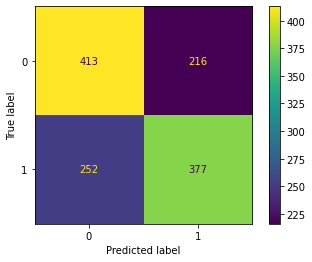

In [27]:
sampled_df['pred_bc'] = result_bc.predict(sampled_df[data_cols_1 + data_cols_2])
prediction_bc = np.round(sampled_df['pred_bc'])
cm_bc = confusion_matrix(sampled_df['target'], prediction_bc)
disp_bc = ConfusionMatrixDisplay(confusion_matrix=cm_bc)
disp_bc.plot()
plt.show()

In [28]:
print(classification_report(sampled_df['target'],  prediction_bc))

              precision    recall  f1-score   support

           0       0.62      0.66      0.64       629
           1       0.64      0.60      0.62       629

    accuracy                           0.63      1258
   macro avg       0.63      0.63      0.63      1258
weighted avg       0.63      0.63      0.63      1258



### Logistic Regrssion Summary
It looks like using the plane of the ball carrier metrics actually reduces the predictive power a little bit, and replacing the plane of field metrics with the plane of ball carrier metrics is even more detrimental.

### Linear Discriminant Analysis
- Did not work, I don't think this is actually what I was looking for it keeps giving me errors

In [29]:
# # Import necessary libraries
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# import matplotlib.pyplot as plt

# # Load the Iris dataset as an example
# # data = load_iris()
# X = sampled_df[data_cols_1]
# y = sampled_df['target']
# target_names = sampled_df['Outcome']

# # Create an LDA model
# lda = LinearDiscriminantAnalysis(n_components=2)  # You can specify the number of components for dimensionality reduction

# # Fit the model to the data
# X_lda = lda.fit(X, y).transform(X)

# # Visualize the results
# plt.figure()
# colors = ['navy', 'turquoise', 'darkorange']
# lw = 2

# for color, i, target_name in zip(colors, [0, 1, 2], target_names):
#     plt.scatter(X_lda[y == i, 0], X_lda[y == i, 1], alpha=.8, color=color,
#                 label=target_name)

# plt.legend(loc='best', shadow=False, scatterpoints=1)
# plt.title('LDA of Tackles dataset')
# plt.show()

# Matching
- match tackles to missed tackles based on momentum of ball carrier (could include x and y)
- observe discernability between defender endzone/sideline momentum vs parallel/perpendicular momentum

## Book Example
- voting machines vs hand ballots
- match districts with voting machines to districts with hand ballots based on the voting record for Dean
- compare the probability of voting for Obama in these paired districts (plot and subtract)
- plot probability of voting for Dean with the difference between the districts prob of voting for Obama
- no correlation is evidence for no fraud

## Tackling Equivalent
- tackles vs missed tackles
- match frames before tackles to frames before missed tackles based on the ???
    * momentum of ball carrier
    * plus endzone/sideline momentum of ball carrier
- compare the enzone/sideline momentum of the defender (and parallel/perpendicular momentum of defender) in these paired frames (plot and subtract)
- plot ball carrier momentum vs defender momentum
    * hoping to see more correlation between parallel/perpendicular momentum than endzone/sideline momentum

In [30]:
# !pip install pymatch

In [31]:
from pymatch.Matcher import Matcher

In [32]:
matching_df = plotting_changes(run_metrics_df)

In [33]:
test = matching_df[matching_df.event == "pff_missedTackle"]
control = matching_df[matching_df.event == "tackle"]
test['missed_tackle'] = 1
control['missed_tackle'] = 0

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [34]:
test.event.value_counts()

pff_missedTackle    629
Name: event, dtype: int64

In [35]:
include_columns = data_cols_1 + data_cols_2 + data_cols_3
ball_carrier_momentum = ['momentum_ball_carrier', 'momentum_x_ball_carrier', 'momentum_y_ball_carrier']
all_columns = list(matching_df.columns)
exclude_columns = list(set(all_columns) - set(include_columns))
second_exclude_columns = list(set(all_columns) - set(ball_carrier_momentum))

In [36]:
m = Matcher(test, control, yvar="missed_tackle", exclude=exclude_columns)

Formula:
missed_tackle ~ x+y+s+a+momentum+momentum_x+momentum_y_abs+in_phase+x_ball_carrier+y_ball_carrier+s_ball_carrier+a_ball_carrier+momentum_ball_carrier+momentum_x_ball_carrier+momentum_y_abs_ball_carrier+in_phase_ball_carrier+contact_angle_momentum+contact_angle_momentum_y_abs
n majority: 6104
n minority: 629


In [37]:
np.random.seed(20231231)
m.fit_scores() #balance=True) #, nmodels=100)

Fitting Models on Balanced Samples: 2\10

/Users/marthawood/.local/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Fitting Models on Balanced Samples: 10\10
Average Accuracy: 67.69%


In [38]:
m.predict_scores()

/opt/anaconda3/lib/python3.7/site-packages/pymatch/Matcher.py:220: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(self.data[self.data[self.yvar]==0].scores, label='Control')
/opt/anaconda3/lib/python3.7/site-packages/pymatch/Matcher.py:221: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(self.data[

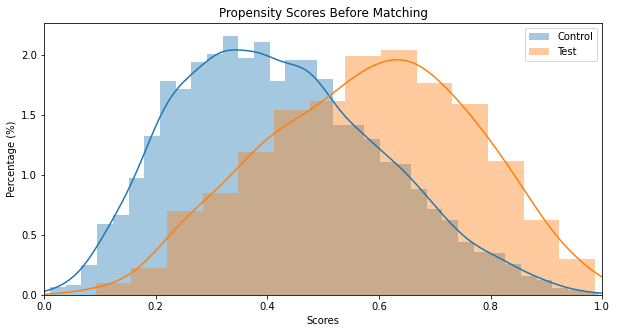

In [39]:
m.plot_scores()

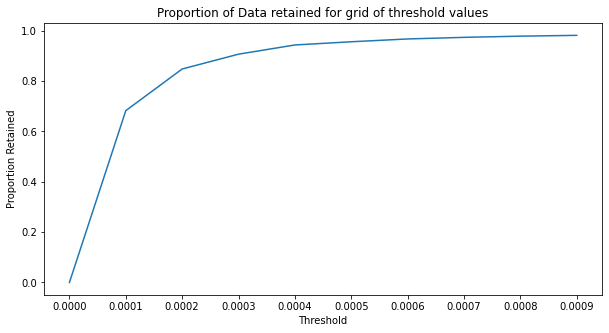

In [40]:
m.tune_threshold(method='random')

In [41]:
m.match(method="min", nmatches=1, threshold=0.0004)
m.record_frequency()

,freq,n_records
0,1,1116
1,2,50
2,3,11
3,4,1
4,5,1


In [42]:
# m.assign_weight_vector()

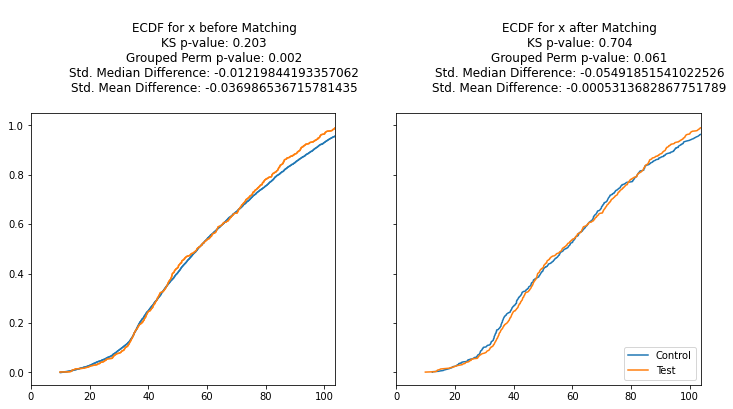

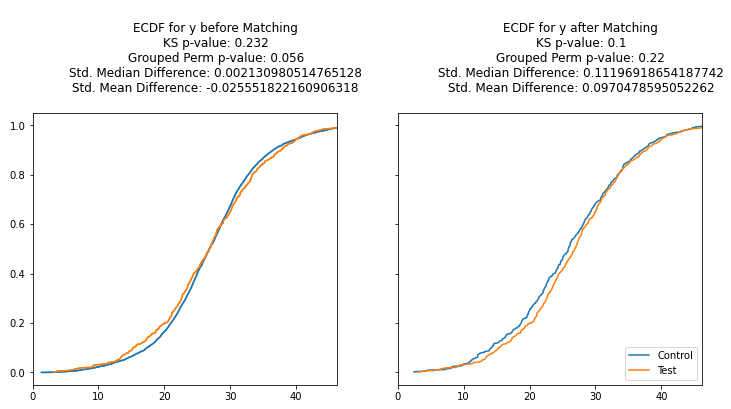

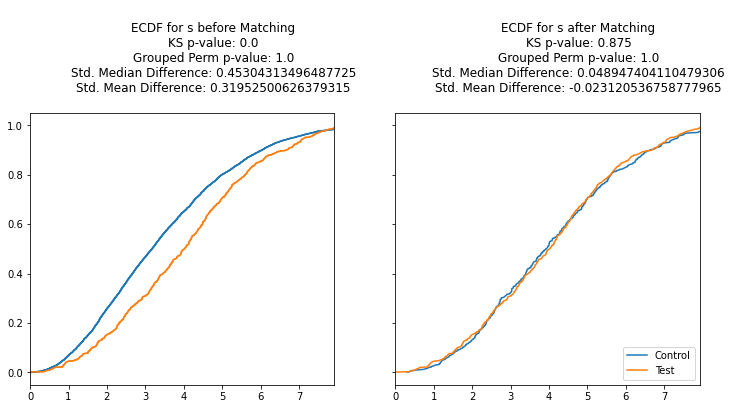

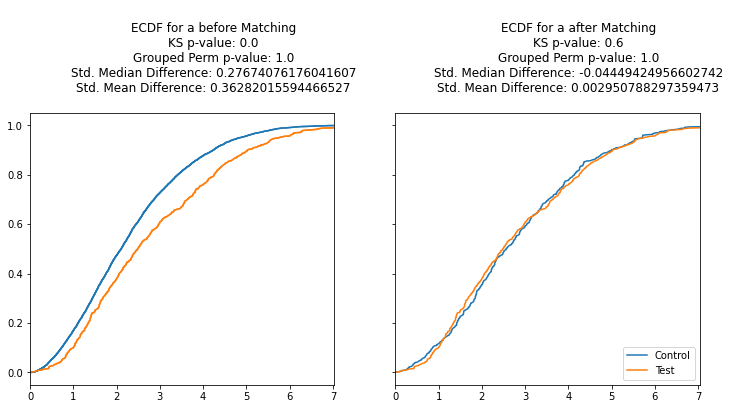

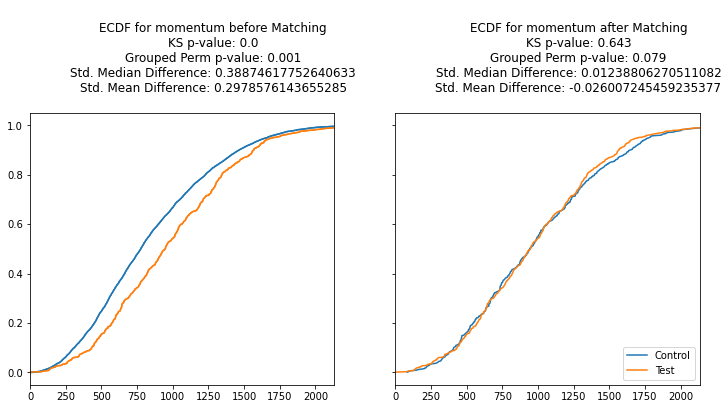

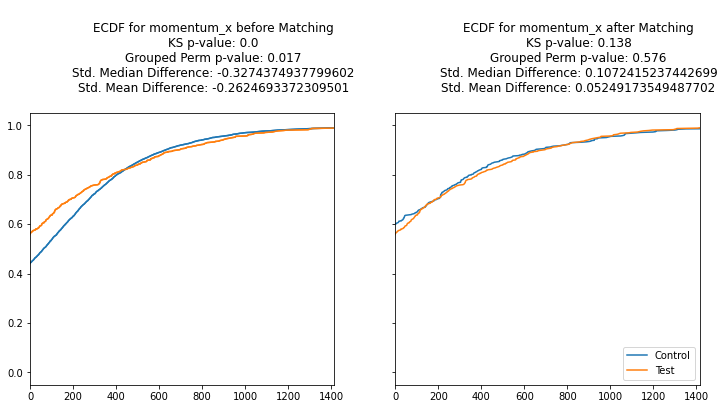

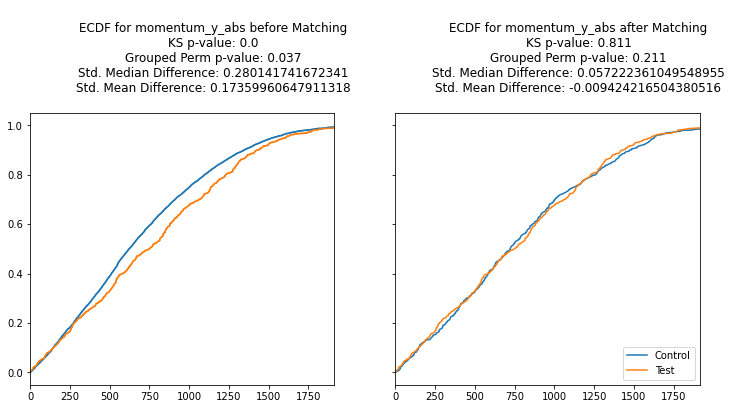

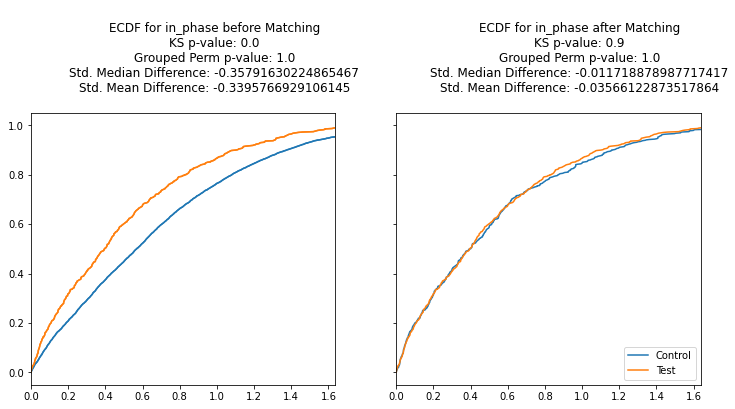

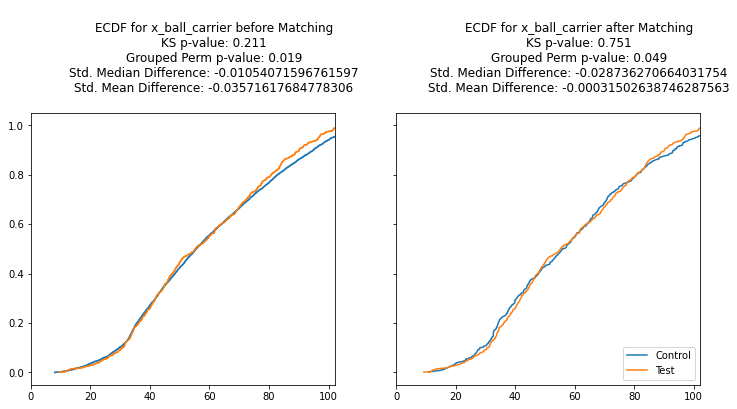

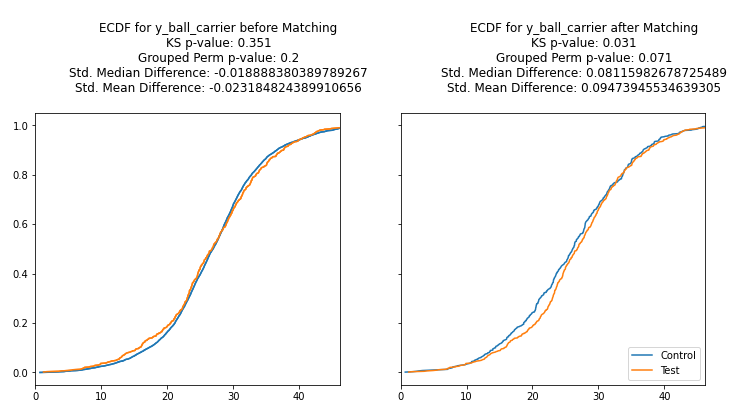

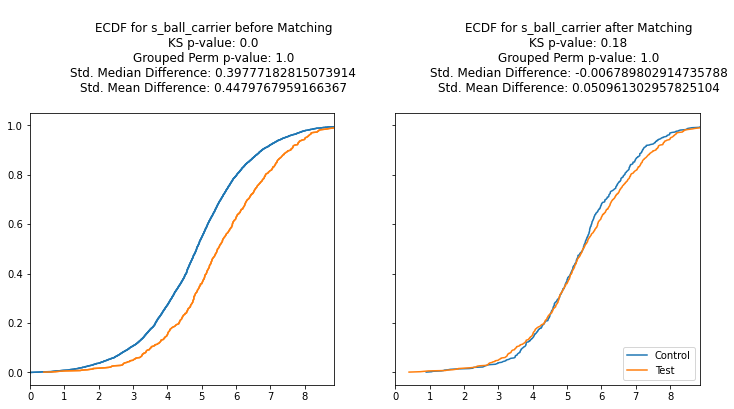

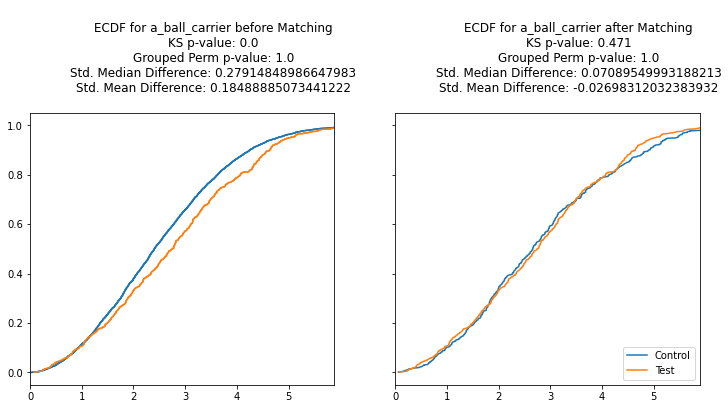

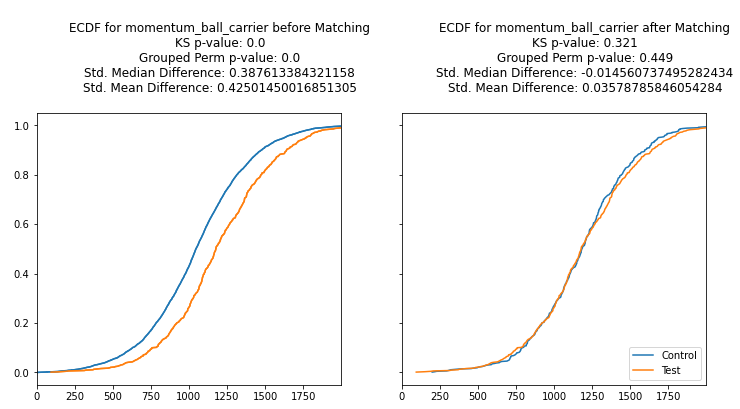

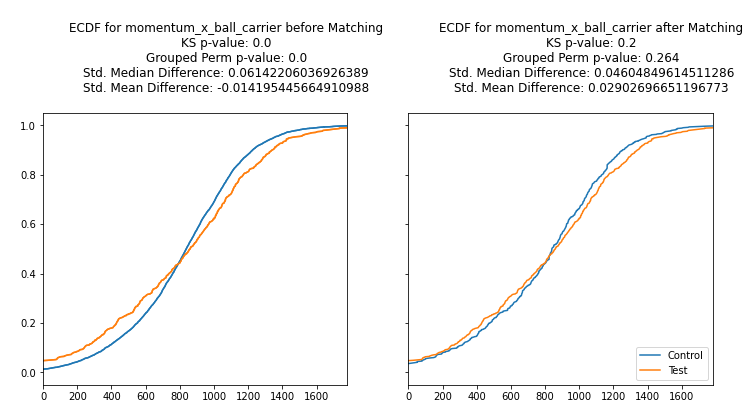

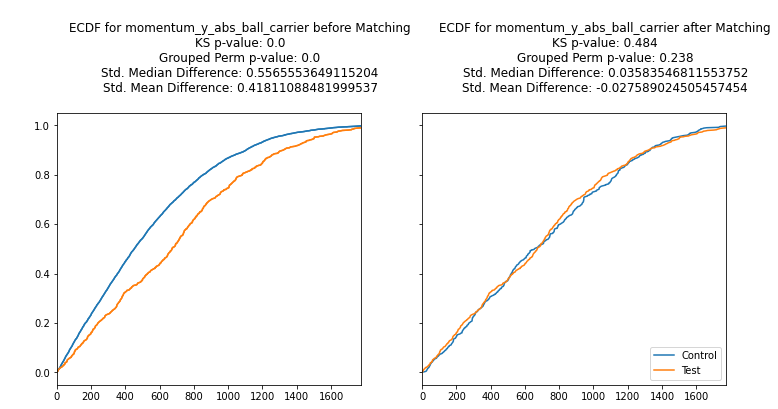

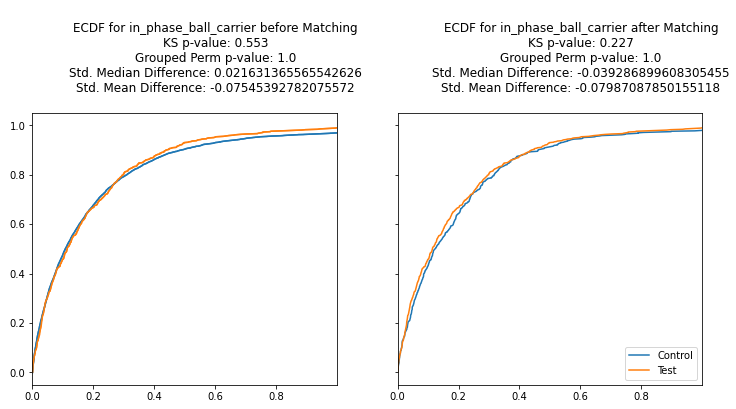

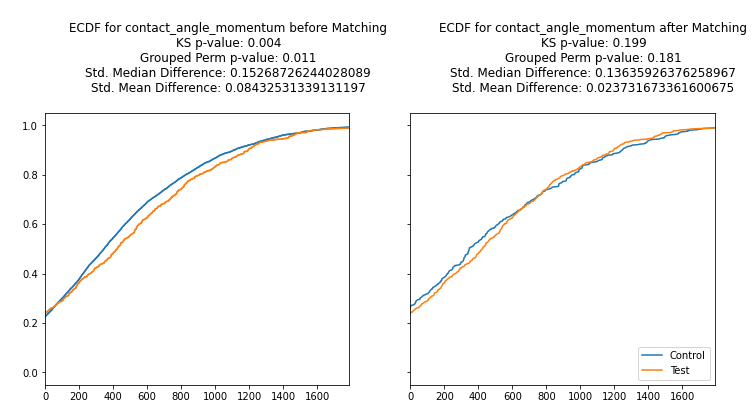

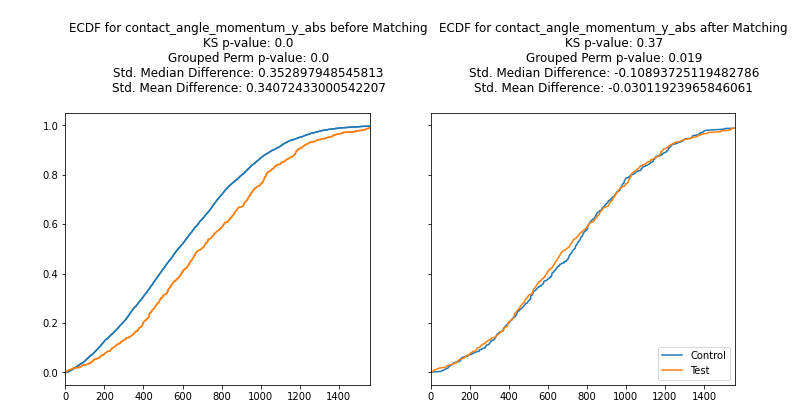

In [43]:
cc = m.compare_continuous(return_table=True)

In [44]:
m.matched_data.sort_values("match_id").head(6)

,gameId,playId,event,nflId,frameId,displayName,club,weight,position,x,...,Ball Carrier Sideline Momentum,Defender Sideline Momentum (abs),Ball Carrier Sideline Momentum (abs),Defender Perpendicular Momentum,Defender Perpendicular Momentum (abs),Defender Parallel Momentum (abs),missed_tackle,scores,match_id,record_id
0,2022090800,1385,pff_missedTackle,40107.0,53,Micah Hyde,BUF,197,FS,97.79,...,-374.299261,598.374147,374.299261,648.384840,648.384840,85.822030,1,0.592307,0,0
6209,2022110600,1262,tackle,46127.0,37,Isaiah Oliver,ATL,210,CB,104.37,...,292.347943,824.736536,292.347943,-970.188905,970.188905,528.085835,0,0.592268,0,6209
1,2022090800,1385,pff_missedTackle,46232.0,36,Tim Settle,BUF,308,DT,84.17,...,671.107985,2055.798343,671.107985,1538.891448,1538.891448,1531.923977,1,0.844170,1,1
6573,2022110608,339,tackle,46711.0,44,Ryan Neal,SEA,200,SS,32.92,...,-1137.501412,1055.171443,1137.501412,-1052.934928,1052.934928,916.593715,0,0.844345,1,6573
2,2022090800,2163,pff_missedTackle,43335.0,37,A'Shawn Robinson,LA,330,DT,79.37,...,319.644385,600.475566,319.644385,445.268257,445.268257,706.253629,1,0.530256,2,2
5342,2022102310,1318,tackle,46164.0,43,Tarvarius Moore,SF,200,SS,57.10,...,71.395182,469.948317,71.395182,511.476332,511.476332,457.152012,0,0.530245,2,5342


Formula:
missed_tackle ~ momentum_ball_carrier+momentum_x_ball_carrier+momentum_y_ball_carrier
n majority: 6104
n minority: 629
Fitting Models on Balanced Samples: 1\10

/Users/marthawood/.local/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Fitting Models on Balanced Samples: 10\10
Average Accuracy: 60.43%


/opt/anaconda3/lib/python3.7/site-packages/pymatch/Matcher.py:220: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(self.data[self.data[self.yvar]==0].scores, label='Control')
/opt/anaconda3/lib/python3.7/site-packages/pymatch/Matcher.py:221: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(self.data[

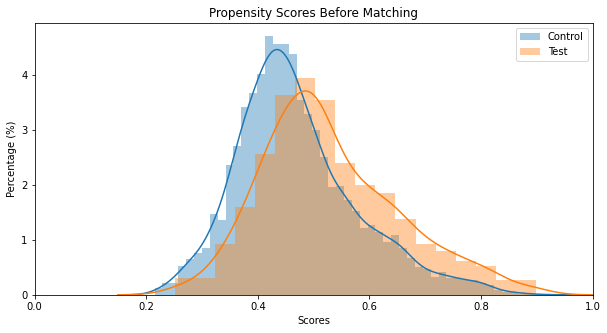

In [45]:
m = Matcher(test, control, yvar="missed_tackle", exclude=second_exclude_columns)
m.fit_scores()
m.predict_scores()
m.plot_scores()

,gameId,playId,event,nflId,frameId,displayName,club,weight,position,x,...,Ball Carrier Sideline Momentum,Defender Sideline Momentum (abs),Ball Carrier Sideline Momentum (abs),Defender Perpendicular Momentum,Defender Perpendicular Momentum (abs),Defender Parallel Momentum (abs),missed_tackle,scores,match_id,record_id
0,2022090800,1385,pff_missedTackle,40107.0,53,Micah Hyde,BUF,197,FS,97.79,...,-374.299261,598.374147,374.299261,648.384840,648.384840,85.822030,1,0.500311,0,0
5497,2022103000,532,tackle,46156.0,30,Arden Key,JAX,240,OLB,33.98,...,-779.418688,1189.724709,779.418688,-814.278863,814.278863,868.332940,0,0.500357,0,5497
1,2022090800,1385,pff_missedTackle,46232.0,36,Tim Settle,BUF,308,DT,84.17,...,671.107985,2055.798343,671.107985,1538.891448,1538.891448,1531.923977,1,0.566814,1,1
2770,2022092900,2233,tackle,52464.0,29,Raekwon Davis,MIA,310,NT,55.66,...,-901.345630,1423.468396,901.345630,-972.912414,972.912414,1051.017733,0,0.566798,1,2770
2,2022090800,2163,pff_missedTackle,43335.0,37,A'Shawn Robinson,LA,330,DT,79.37,...,319.644385,600.475566,319.644385,445.268257,445.268257,706.253629,1,0.500006,2,2
5518,2022103000,2511,tackle,47790.0,24,Josh Allen,JAX,262,OLB,29.61,...,-532.483994,1411.079260,532.483994,-1142.064114,1142.064114,895.814573,0,0.500001,2,5518


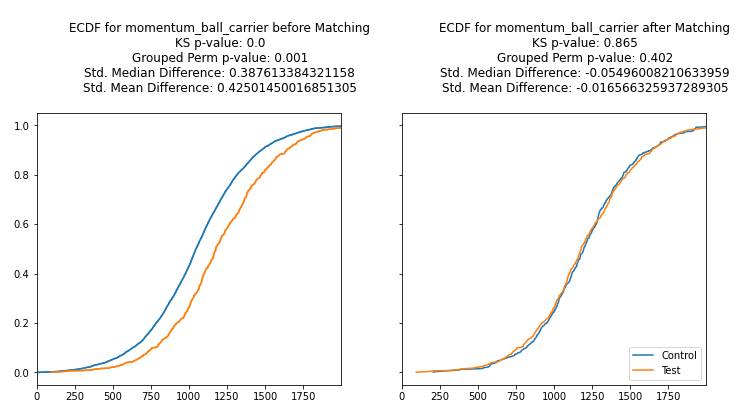

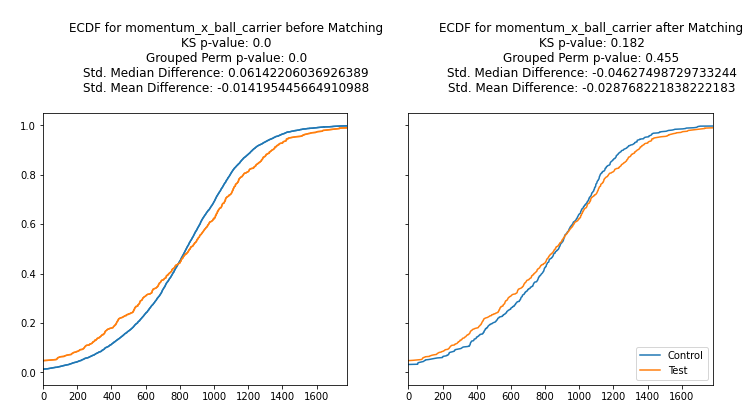

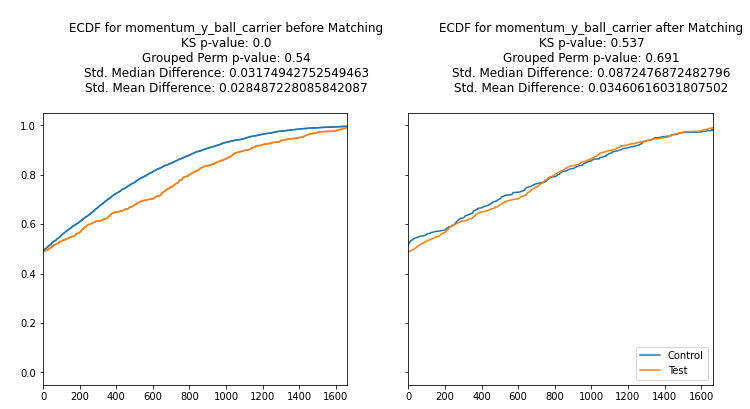

In [46]:
m.match(method="min", nmatches=1, threshold=0.0004)
cc = m.compare_continuous(return_table=True)
m.matched_data.sort_values("match_id").head(6)

In [47]:
all_columns
original_columns = [
 'nflId',
 'club',
 'x',
 'y',
 's',
 'a',
 'dis',
 'o',
 'dir',
 'nflId_ball_carrier',
 'club_ball_carrier',
 'x_ball_carrier',
 'y_ball_carrier',
 's_ball_carrier',
 'a_ball_carrier',
 'dis_ball_carrier',
 'o_ball_carrier',
 'dir_ball_carrier'
]
third_exclude_columns = list(set(all_columns) - set(original_columns))

Formula:
missed_tackle ~ nflId+club+x+y+s+a+dis+o+dir+nflId_ball_carrier+club_ball_carrier+x_ball_carrier+y_ball_carrier+s_ball_carrier+a_ball_carrier+dis_ball_carrier+o_ball_carrier+dir_ball_carrier
n majority: 6104
n minority: 629
Fitting Models on Balanced Samples: 1\10

/Users/marthawood/.local/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Fitting Models on Balanced Samples: 10\10
Average Accuracy: 68.66%


/opt/anaconda3/lib/python3.7/site-packages/pymatch/Matcher.py:220: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(self.data[self.data[self.yvar]==0].scores, label='Control')
/opt/anaconda3/lib/python3.7/site-packages/pymatch/Matcher.py:221: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(self.data[

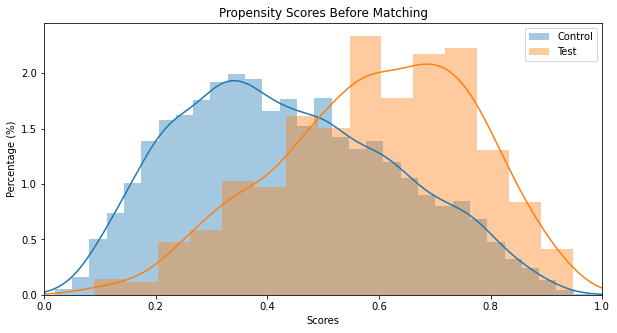

In [48]:
# fit on original tracking data
m = Matcher(test, control, yvar="missed_tackle", exclude=third_exclude_columns)
m.fit_scores()
m.predict_scores()
m.plot_scores()

,gameId,playId,event,nflId,frameId,displayName,club,weight,position,x,...,Ball Carrier Sideline Momentum,Defender Sideline Momentum (abs),Ball Carrier Sideline Momentum (abs),Defender Perpendicular Momentum,Defender Perpendicular Momentum (abs),Defender Parallel Momentum (abs),missed_tackle,scores,match_id,record_id
0,2022090800,1385,pff_missedTackle,40107.0,53,Micah Hyde,BUF,197,FS,97.79,...,-374.299261,598.374147,374.299261,648.384840,648.384840,85.822030,1,0.572358,0,0
2957,2022100203,2143,tackle,52852.0,70,Myles Hartsfield,CAR,211,FS,34.51,...,-43.714585,641.237426,43.714585,639.008875,639.008875,55.793652,0,0.572373,0,2957
1,2022090800,1385,pff_missedTackle,46232.0,36,Tim Settle,BUF,308,DT,84.17,...,671.107985,2055.798343,671.107985,1538.891448,1538.891448,1531.923977,1,0.755764,1,1
4184,2022101000,1022,tackle,38551.0,26,Chandler Jones,LV,265,DE,33.34,...,987.304931,851.017205,987.304931,649.381422,649.381422,577.765011,0,0.755556,1,4184
2,2022090800,2163,pff_missedTackle,43335.0,37,A'Shawn Robinson,LA,330,DT,79.37,...,319.644385,600.475566,319.644385,445.268257,445.268257,706.253629,1,0.593817,2,2
6054,2022103012,1097,tackle,46190.0,45,Taron Johnson,BUF,192,CB,79.51,...,284.302675,1193.512501,284.302675,1146.179354,1146.179354,335.383462,0,0.593665,2,6054


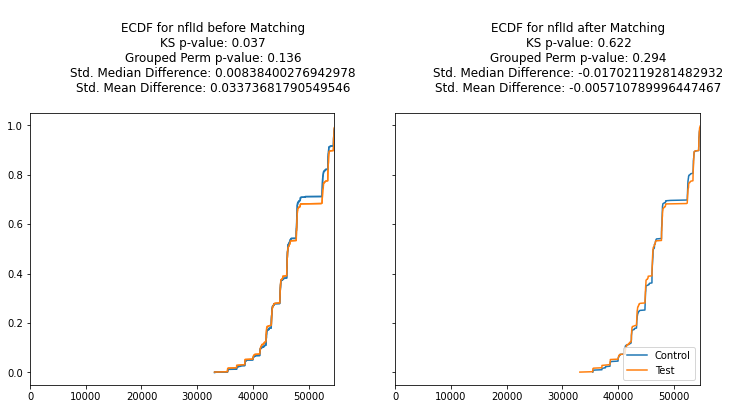

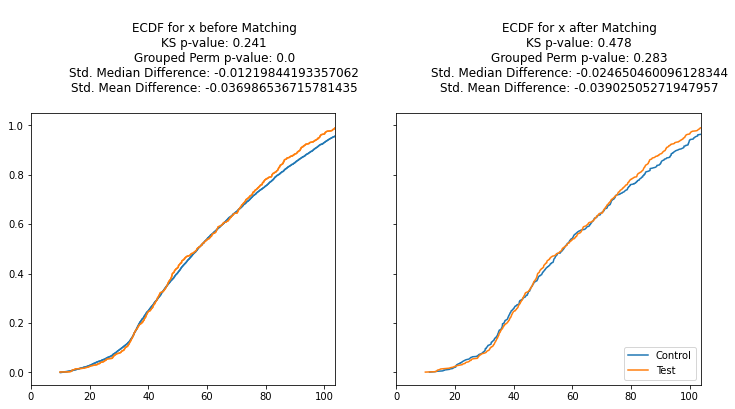

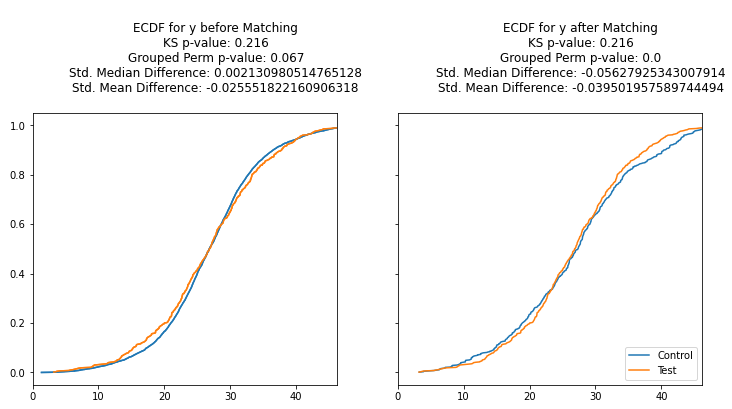

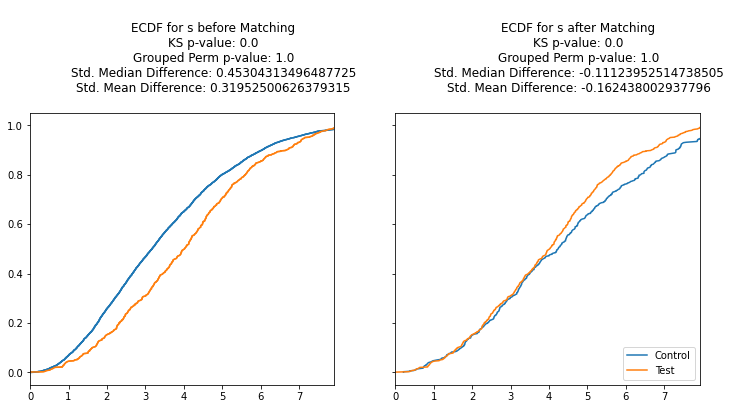

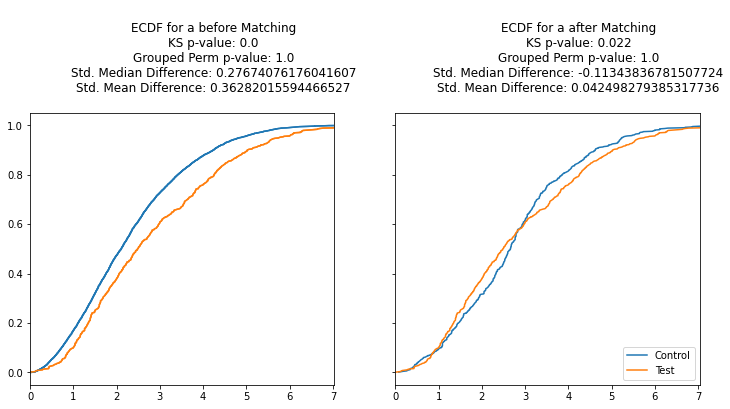

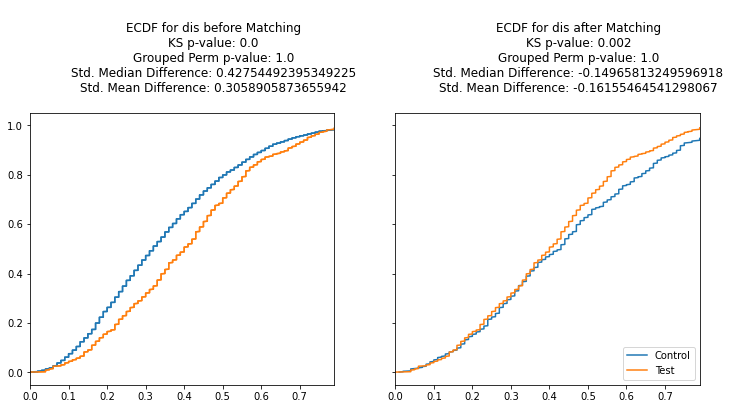

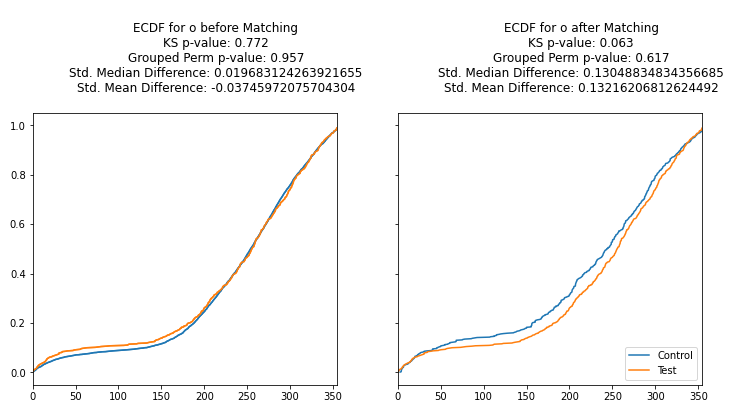

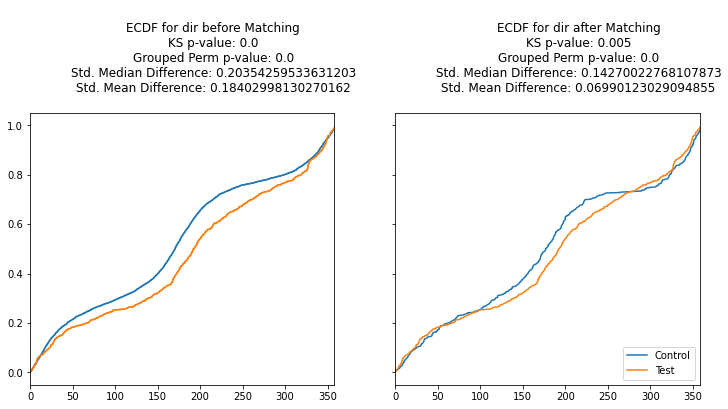

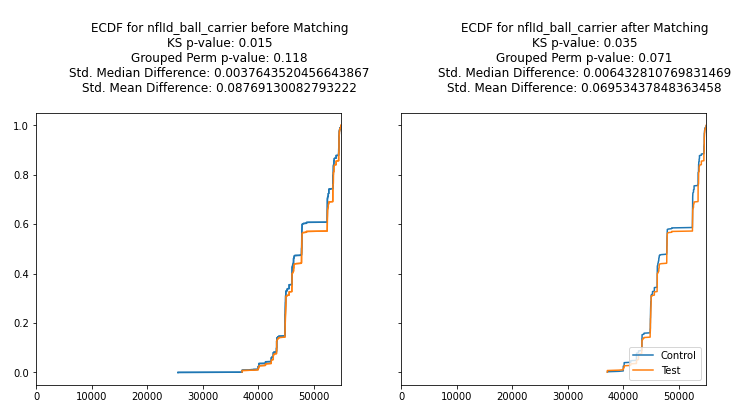

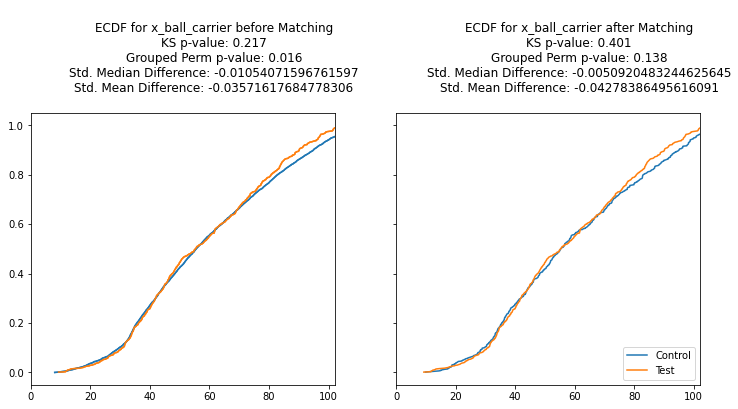

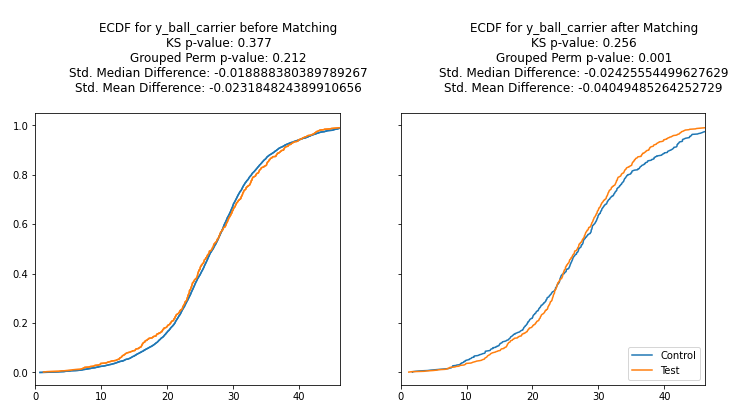

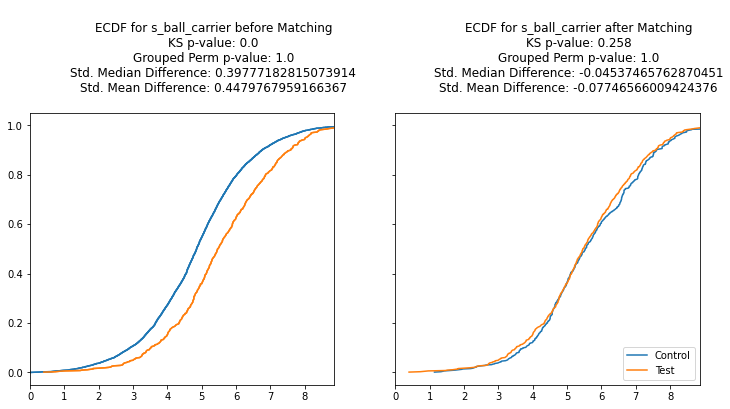

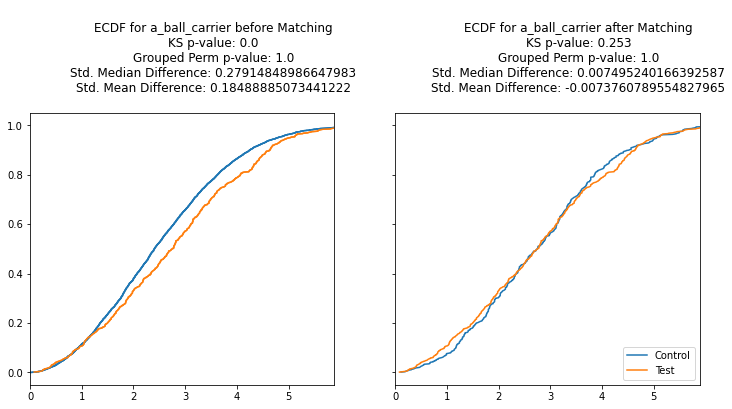

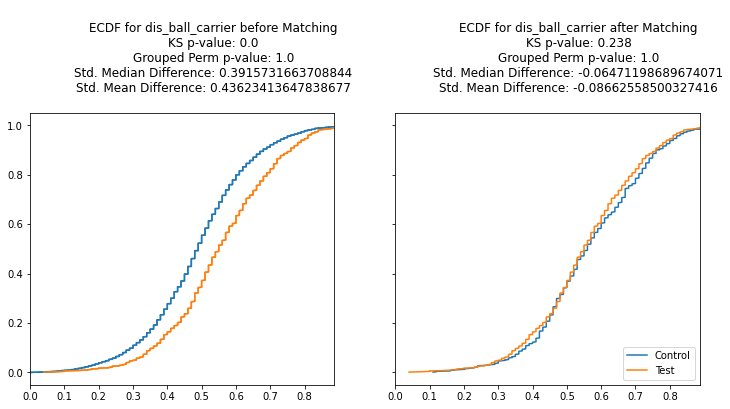

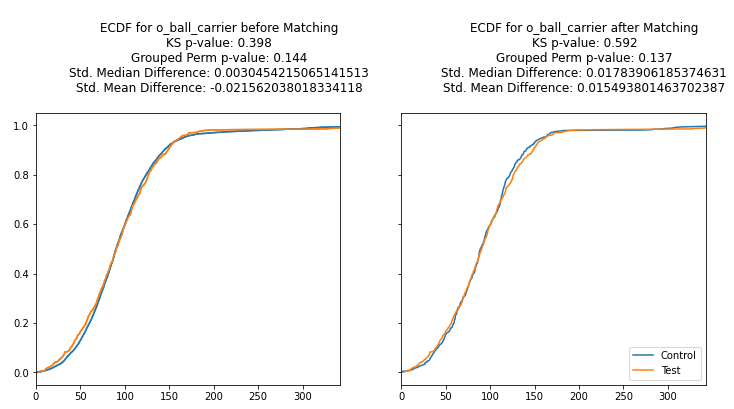

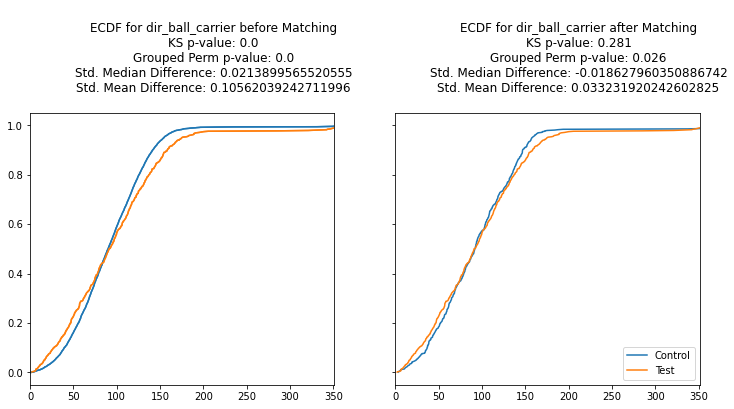

In [49]:
m.match(method="min", nmatches=1, threshold=0.0004)
cc = m.compare_continuous(return_table=True)
m.matched_data.sort_values("match_id").head(6)

# Looking for Interesting Details

**Heat map plots aren't very informative because there isn't much information. I think this could be better for position groups. Try that later**

In [50]:
linemen = ['DT', 'DE', 'NT']
linebackers = ['ILB', 'OLB', 'MLB']
backs = ['CB', 'SS', 'FS', 'DB']

In [51]:
position_df = sampled_df[sampled_df['position'].isin(linemen)]

In [52]:
position_df['contact_angle_momentum'].max()

2097.937048689951

In [53]:
def tackles_heatmap(df, missed):
    if missed:
        event = 'pff_missedTackle'
        color = 'Blues'
    else:
        event = 'tackle'
        color = 'Oranges'
    tackles_df = df[df['event'] == event].copy()
    tackles_df['Parallel Momentum'] = pd.cut(tackles_df['contact_angle_momentum'],
                                                bins=[-2500, -2000, -1500, -1000, -750, -500, -250, 0,
                                                      250, 500, 750, 1000, 1500, 2000, 2500, 3000],
                                                labels=[-2500, -2000, -1500, -1000, -750, -500, -250, 0,
                                                      250, 500, 750, 1000, 1500, 2000, 2500]
                                               )
    tackles_df['Perpendicular Momentum'] = pd.cut(tackles_df['contact_angle_momentum_y'],
                                                     bins=[-2500, -2000, -1500, -1000, -750, -500, -250, 0,
                                                      250, 500, 750, 1000, 1500, 2000, 2500, 3000],
                                                labels=[-2500, -2000, -1500, -1000, -750, -500, -250, 0,
                                                      250, 500, 750, 1000, 1500, 2000, 2500]
                                               )

    heatmap_data = tackles_df.groupby(['Parallel Momentum', 'Perpendicular Momentum'], as_index=False)['event'].count().pivot(index='Parallel Momentum', columns='Perpendicular Momentum', values='event')

    sns.heatmap(heatmap_data, cmap=color)

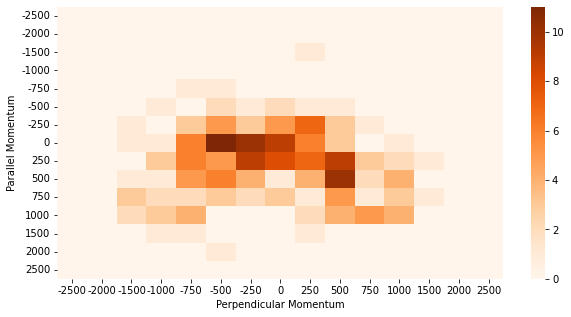

In [54]:
tackles_heatmap(position_df, False)

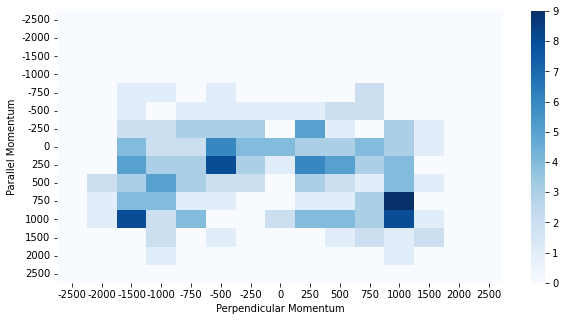

In [55]:
tackles_heatmap(position_df, True)

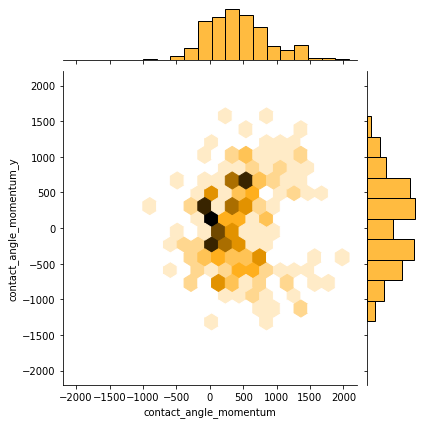

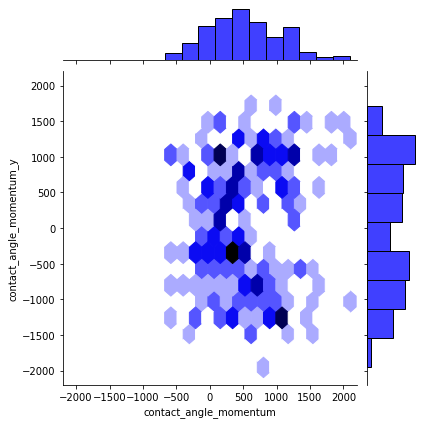

In [56]:
position_tackle_df = position_df[position_df['event'] == 'tackle']
sns.jointplot(data=position_tackle_df,
              x='contact_angle_momentum',
              y='contact_angle_momentum_y',
              kind="hex",
              color='orange',
              joint_kws=dict(gridsize=15),
              xlim=(-2200, 2200),
              ylim=(-2200, 2200)
             )
position_missed_tackle_df = position_df[position_df['event'] == 'pff_missedTackle']
sns.jointplot(data=position_missed_tackle_df,
              x='contact_angle_momentum',
              y='contact_angle_momentum_y',
              kind="hex",
              color='blue',
              joint_kws=dict(gridsize=15),
              xlim=(-2200, 2200),
              ylim=(-2200, 2200)
             )

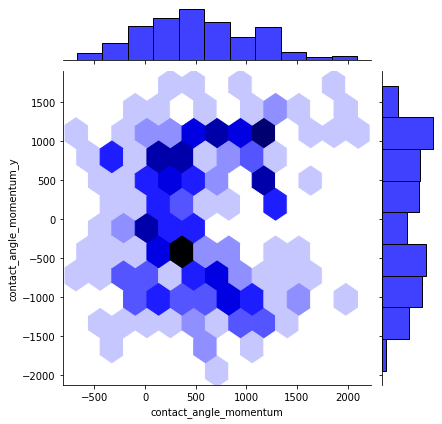

In [57]:
position_missed_tackle_df = position_df[position_df['event'] == 'pff_missedTackle']
sns.jointplot(data=position_missed_tackle_df,
              x='contact_angle_momentum',
              y='contact_angle_momentum_y',
              kind="hex",
              color='blue',
              joint_kws=dict(gridsize=12)
             )